# Lecture 11 Demo: Posterior predictive checks

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from pymc3 import glm
import arviz as az
sns.set()

### Create OK turbines data set

In [6]:
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)
turbines.head()

,t_state,t_built,t_cap,year
0,AK,6,390.0,-3.0
1,AK,6,475.0,-1.0
2,AK,2,100.0,0.0
3,AK,1,1500.0,1.0
4,AK,1,100.0,2.0


In [7]:
# Turbines in Oklahoma
ok_filter = (turbines.t_state == 'OK') & (turbines.year >= 0)
ok_turbines = turbines[ok_filter].sort_values('year')
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])

### Draw posterior samples from Gaussian, Poisson and negative binomial models

In [8]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)

with pm.Model() as gaussian_model:
    # Specify glm and pass in data. This is similar to the code from
    # Lab 3 that created `theta = pm.Beta(...)`, etc., but using PyMC3's 
    # GLM module sets everything up automaticaly. 
    # The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula('log_totals ~ year', ok_turbines)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=2, target_accept=0.95)
    
# Not counting variable name changes, there are two differences 
# between this cell and the version we did before: can you find them?
with pm.Model() as poisson_model:
    glm.GLM.from_formula('totals ~ year', ok_turbines, family=glm.families.Poisson())
    # draw posterior samples using NUTS sampling
    poisson_trace = pm.sample(1000, cores=2, target_accept=0.95)


with pm.Model() as negbin_model:
    glm.GLM.from_formula('totals ~ year', ok_turbines, family=glm.families.NegativeBinomial())
    # draw posterior samples using NUTS sampling
    negbin_trace = pm.sample(1000, cores=2, target_accept=0.95)

/tmp/ipykernel_24/11348518.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  gaussian_trace = pm.sample(1000, cores=2, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, year, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
/tmp/ipykernel_24/11348518.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  poisson_trace = pm.sample(1000, cores=2, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, year, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
/tmp/ipykernel_24/11348518.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  negbin_trace = pm.sample(1000, cores=2, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, year, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [9]:
poisson_trace['year']

array([0.18276264, 0.18196616, 0.18187537, ..., 0.18180752, 0.18183235,
       0.18215786])

## Credible intervals for coefficients

In [10]:
β_year_samples = negbin_trace['year']
β_year_samples

array([0.22088704, 0.23019972, 0.23461718, ..., 0.24547829, 0.25445352,
       0.23471608])

In [11]:
β_year_samples.shape

(2000,)

(array([  3.,   3.,   3.,  14.,  34.,  76., 120., 205., 262., 337., 335.,
        240., 170.,  97.,  55.,  19.,  12.,   5.,   7.,   3.]),
 array([0.11942477, 0.13156762, 0.14371048, 0.15585333, 0.16799618,
        0.18013903, 0.19228188, 0.20442474, 0.21656759, 0.22871044,
        0.24085329, 0.25299614, 0.26513899, 0.27728185, 0.2894247 ,
        0.30156755, 0.3137104 , 0.32585325, 0.33799611, 0.35013896,
        0.36228181]),
 <BarContainer object of 20 artists>)

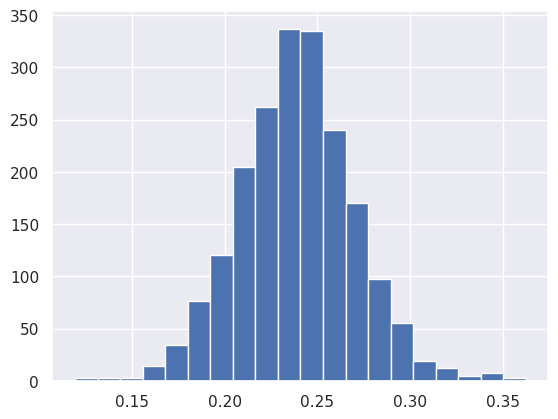

In [12]:
plt.hist(β_year_samples, bins=20)

In [13]:
sorted_samples = np.sort(β_year_samples)
sorted_samples

array([0.11942477, 0.12179607, 0.12432532, ..., 0.35316032, 0.36213128,
       0.36228181])

In [14]:
0.95 * 2000

1900.0

In [15]:
sorted_samples[:1900]

array([0.11942477, 0.12179607, 0.12432532, ..., 0.28930384, 0.28933486,
       0.2895472 ])

In [16]:
0.288 - 0.138

0.14999999999999997

In [17]:
sorted_samples[100:2000]

array([0.18868333, 0.18869092, 0.18881772, ..., 0.35316032, 0.36213128,
       0.36228181])

In [18]:
0.358 - 0.194

0.16399999999999998

In [19]:
sorted_samples[40:1940]

array([0.17415211, 0.17441136, 0.17544495, ..., 0.29621778, 0.2966495 ,
       0.29696407])

In [20]:
0.295 - 0.181

0.11399999999999999

### Draw posterior predictive samples from Gaussian, Poisson and negative binomial models

We use PyMC3's `sample_posterior_predictive`:

In [21]:
with gaussian_model:
    gaussian_ppc = pm.sample_posterior_predictive(
        gaussian_trace, var_names=["year", "Intercept", "y"]
    )

In [22]:
with poisson_model:
    poisson_ppc = pm.sample_posterior_predictive(
        poisson_trace, var_names=["year", "Intercept", "y"]
    )

In [23]:
with negbin_model:
    negbin_ppc = pm.sample_posterior_predictive(
        negbin_trace, var_names=["year", "Intercept", "y"]
    )

In [33]:
negbin_ppc

{'year': array([0.22088704, 0.23019972, 0.23461718, ..., 0.24547829, 0.25445352,
        0.23471608]),
 'Intercept': array([4.51208039, 4.2686655 , 4.31509783, ..., 4.18148262, 4.04335691,
        4.21057468]),
 'y': array([[  205,   108,   310, ...,  4373, 10755, 13293],
        [   70,   208,   243, ...,  6419, 12672,  6433],
        [   80,   152,   255, ...,  7372,  3831,  7449],
        ...,
        [  103,    55,    97, ...,  3840,  4972,  5280],
        [   78,    54,   168, ...,  2656, 15923,  5515],
        [   43,    62,   117, ...,  5658,  9861, 10956]])}

In [34]:
negbin_ppc['y'].shape

(2000, 17)

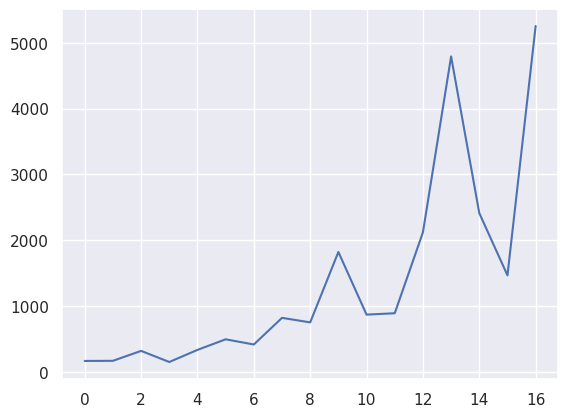

In [35]:
plt.plot(negbin_ppc['y'][47, :])

In GLMs, we have the "average prediction" $\bar{y} =$ InverseLinkFunction$(X\beta)$, and then we have the actual predictions themselves, which are randomly distributed around this average, based on the chosen likelihood model.

For example, suppose `year = 4`, the coefficient $\beta_{year}$ is 0.19, and the intercept is 4.8. Then the average prediction $\bar{y}$ for that year will be $\exp(4 \cdot 0.19 + 4.8)$:

In [24]:
np.exp(4 * 0.19 + 4.8)

259.8228363229507

In [ ]:
np.exp(4 * 0.23 + 4.8)

or, about 260 turbines. The actual distribution for the number of turbines we actually observe will be a negative binomial with mean 259.8 (and variance estimated from the data).

Note that there is uncertainty in the average prediction too: the coefficient 0.19 in the example above could have been different. So, it's important to track our uncertainty at two levels:

* The uncertainty for the average prediction at each point (we'll also call this the 'regression output') reflects how uncertain we are about the coefficients, and what that means for the average prediction
* The uncertainty for the actual observed data reflects how much variation around the mean we should expect based on our data.

### Plot posterior predictive distribution for each model

In [25]:
def compute_avg_prediction(ppc):
    linear_part = np.outer(ppc["year"], ok_turbines.year.values) + ppc["Intercept"][:,np.newaxis]
    return np.exp(linear_part)

In [27]:
# Compute the posterior regression function (y hat values) for each model
y_hat_poisson = compute_avg_prediction(poisson_ppc)
y_hat_negbin = compute_avg_prediction(negbin_ppc)
y_hat_gaussian = compute_avg_prediction(gaussian_ppc)
y_hat_vals = [y_hat_poisson, y_hat_gaussian, y_hat_negbin]

/opt/conda/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


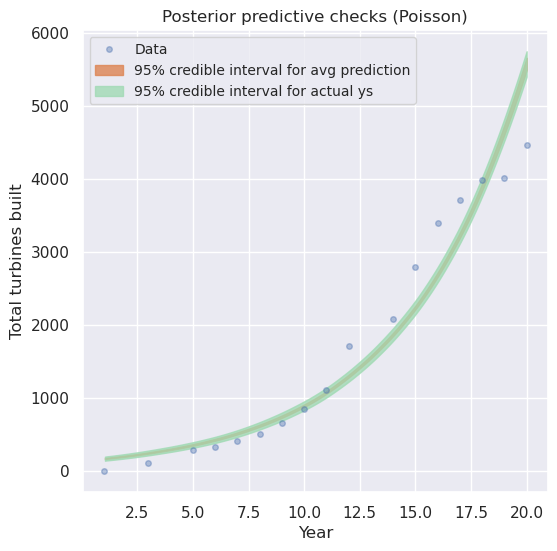

In [28]:
_, ax = plt.subplots(figsize = (6,6))

ax.plot(ok_turbines.year, ok_turbines.totals, "o", ms=4, alpha=0.4, label="Data")
az.plot_hdi(
    ok_turbines.year,
    y_hat_poisson,
    ax=ax,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.8, "label": "95% credible interval for avg prediction"},
)
az.plot_hdi(
    ok_turbines.year,
    poisson_ppc["y"],
    ax=ax,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for actual ys"},
)

ax.set_xlabel("Year")
ax.set_ylabel("Total turbines built")
ax.set_title("Posterior predictive checks (Poisson)")
ax.legend(fontsize=10);

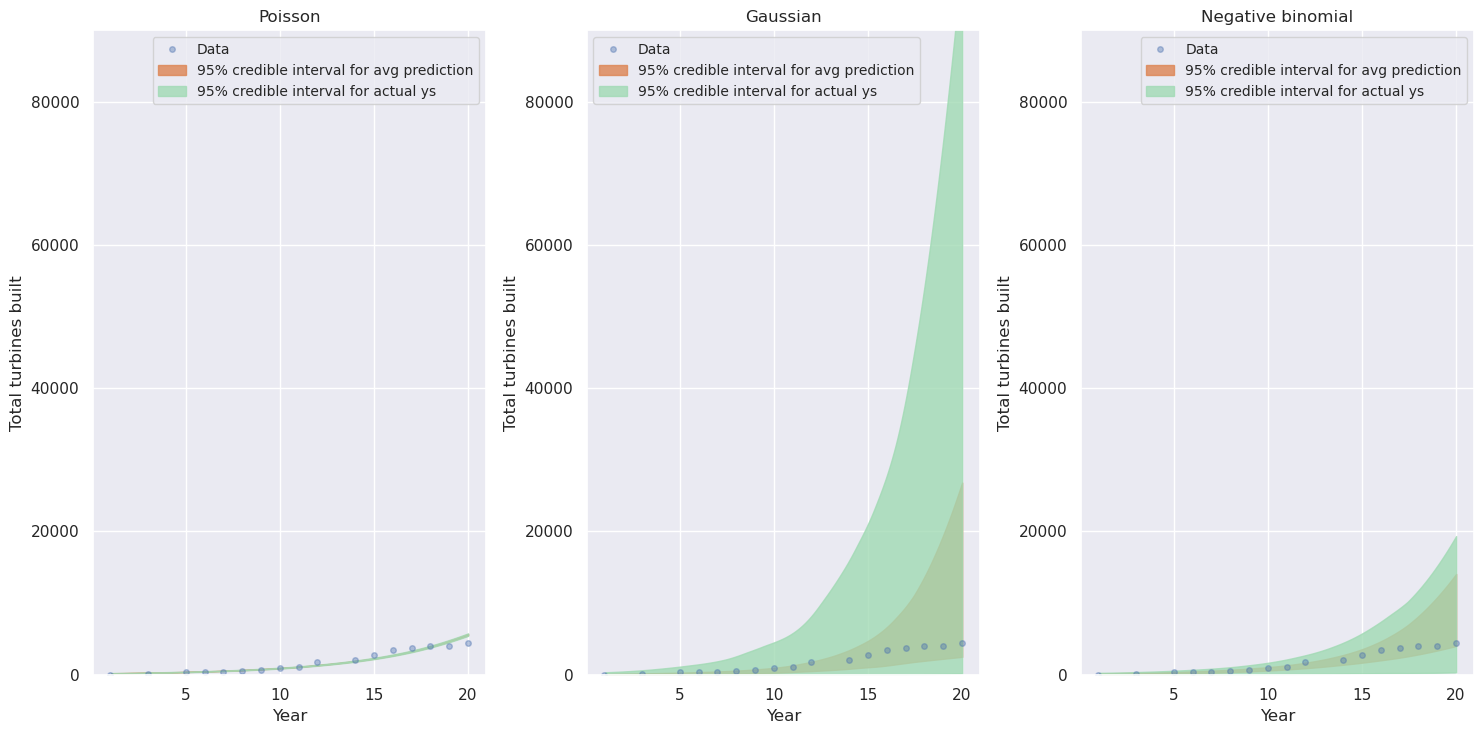

In [32]:
_, ax = plt.subplots(1,3, figsize = (15,7.5), dpi=100)
names = ["Poisson", "Gaussian", "Negative binomial"]

for idx, ppc in enumerate([poisson_ppc, gaussian_ppc, negbin_ppc]):
    ax[idx].plot(ok_turbines.year, ok_turbines.totals, "o", ms=4, alpha=0.4, label="Data")
    az.plot_hdi(
        ok_turbines.year,
        y_hat_vals[idx],
        ax=ax[idx],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for avg prediction"},
    )
    if idx==1:
        pp_y = np.exp(ppc["y"])
    else:
        pp_y = ppc["y"]
    az.plot_hdi(
        ok_turbines.year,
        pp_y,
        ax=ax[idx],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for actual ys"},
    )

    ax[idx].set_xlabel("Year")
    ax[idx].set_ylabel("Total turbines built")
    ax[idx].set_title(names[idx])
    ax[idx].legend(fontsize=10)
    ax[idx].set_ylim(-100, 90000)
plt.tight_layout()